CS 28150 HW 6

Zack Wang

Backwards/implicit Euler's method is a bit harder: in order to solve for each step, we consider the formula:

$Y_{new}$ = $Y_{old}$ + $ dt * f(Y_{new})$ where

$f(Y_{new})$ $\approx$ $A(Y_{new})$ = $f(Y_{old})$ + $Df(Y_{old})$ * ($Y_{new} - Y_{old}$)

This is tricky, as we must move around the $Y_{new}$ term in order to actually solve for it. Doing so, we get:

$Y_{new}$ = $\frac{Y_{old} + (dt * f(Y_{old})) - (dt * Df(Y_{old})}{Identity - (dt * Df(Y_{old}))}$

Note that because we are dealing with systems, we can simplify this to solving the systems of equations:

$[(I - dt * Df(y)]$ $* DY = dt * f(Y)$

////////////////////////////////////////////////////////////

For the spiral model we have:

a graph for alpha = .25, which shows a loose spiral closing into a circle. The corresponding log(dt) graph shows it having very small steps, then growing to dt max.

a graph for alpha = 200. The spiral immediately zones in, becoming the circle. The corresponding log(dt) graph shows it zooming to the dt max after reaching the circle. 

////////////////////////////////////////////////////////////

For the reaction model we have:

three graphs of the estimation with tolerance equaling $1e^{-3}$. These graphs don't give much information, just look like squiggles. 

three control graphs of estimation with tolerance $1e^{-6}$. These show three huge spikes, and a flat line everywhere else. 

three graphs where we zoom into t = [300, 325]. These show the large spikes for the control model, but basically flat lines for the $1e^{-3}$ model.

log(dt) graph for the $1e^{-3}$ model shows it hits the dtmax stepsize relatively quickly and stays there (does not assume the function is too stiff)

err of $1e^{-3}$ model has large spikes at beginning but a flat line everywhere else. err of control shows a periodic and consistent pattern.

Table of steps accepted vs rejected show the $1e^{-3}$ model scarcely ever rejects a step, whereas the control rejects 10% of all the steps, and takes significantly more.

*For the $1e^{-4}$ model, we have 3 standalone graphs of the components, as well as the closeups. In the standalones, we can actually see the three spikes seen in the control model. In the closeups we see that the spikes are quite smaller, and a bit delayed, but they still match up with the control. 

The err and log(dt) graphs show that this model does correctly identify the spikes, and is just slow to adapt to the rapid change. The log(dt) graph has periodic spikes where it slows down. 

The table of steps accepted also confirm this, with the $1e^{-4}$ model have significantly more steps taken AND rejected than the $1e^{-3}$ model.

In [256]:
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use('seaborn-whitegrid')

class simTime:
    time = 0
    dt = 1
    tol = .1
    agrow = 1.25
    ashrink = .8
    dtmin = .2
    dtmax = 2
    endTime = 5
    stepsSinceRejection = 0
    stepsRejected = 0
    stepsAccepted = 0
    def __init__(self, t, tol, agrow, ashrink, dtmin, dtmax, endt):
        self.time = t
        self.tol = tol
        self.agrow = agrow
        self.ashrink = ashrink
        self.dtmin = dtmin
        self.dt = dtmin
        self.dtmax = dtmax
        self.endTime = endt

    def successStep(self):
        self.time += self.dt
        self.stepsSinceRejection += 1
        if self.stepsSinceRejection > 3:
            potential = self.agrow * self.dt
            if potential > self.dtmax:
                self.dt = self.dtmax
            elif potential < self.dtmin:
                self.dt = self.dtmin
            else:
                self.dt = potential
            #need something here, set dt to end up exactly at self.edntime if necessary
            if (self.time + self.dt) > self.endTime:
                self.dt = self.endTime - self.time
        self.stepsAccepted += 1

    def cautiousStep(self):
        self.time += self.dt
        self.stepsSinceRejection += 1
        potential = self.ashrink * self.dt
        if potential > self.dtmax:
            self.dt = self.dtmax
        elif potential < self.dtmin:
            self.dt = self.dtmin
        else:
            self.dt = potential
        if (self.time + self.dt) > self.endTime:
                self.dt = self.endTime - self.time
        self.stepsAccepted += 1

    def takeIt(self):
        self.time += self.dt
        self.stepsAccepted += 1

    def failedStep(self):
        self.dt /= 2
        self.stepsSinceRejection = 0
        self.stepsRejected += 1

        


def step1(y, t, dt, foo, alpha):

    fOfY = foo[0](alpha, y)
    dfOfY = foo[1](alpha, y)
    leftTerm = np.identity(len(y)) - (dt * dfOfY)
    rightTerm = dt * fOfY
    changeY = np.linalg.solve(leftTerm, rightTerm)
    w = y + changeY
    return w

def step2(y, t, dt, f, alpha, norm):
    initalGuess = step1(y, t, dt, f, alpha)
    wHalfway = step1(y, t, dt/2, f, alpha)
    wRest = step1(wHalfway, t + (dt / 2), dt/2, f, alpha)
    ddy = wRest - initalGuess
    w = wRest + ddy
    return w, norm(ddy)

def chart(startt, starty, end, foo, st, alpha, norm = np.linalg.norm):
    #traverses the whole thing
    xs = []
    ys = []
    errs = []
    t = startt
    y = starty
    ys.append(y)
    xs.append(t)
    errs.append(0)
    while (st.time < end):
        testStep, err = step2(y, st.time, st.dt, foo, alpha, norm) 
        #print(err)
        if err < st.tol:
            if err > (.75 * st.tol):
                #print("close enough")
                st.cautiousStep()
                ys.append(testStep)
                xs.append(st.time)
                errs.append(err)
                y = testStep
            else:
                st.successStep()
                ys.append(testStep)
                xs.append(st.time)
                errs.append(err)
                y = testStep
        
        else:
            if st.dt <= st.dtmin:
                st.takeIt()
                ys.append(testStep)
                xs.append(st.time)
                errs.append(err)
                y = testStep
            else:
                st.failedStep()
    return xs, ys, st, errs
    

Steps Accepted:  207
Steps Rejected:  0


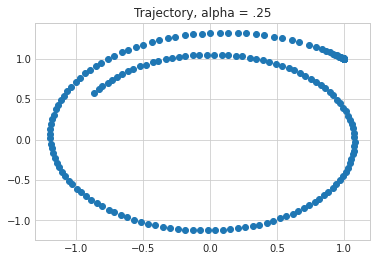

In [257]:
#Problem 1: Stable Circular Orbit
def orbit1(alpha, y):
    val1 = (-alpha * (np.sqrt((y[0] ** 2) + (y[1] ** 2)) - 1) * y[0]) - y[1]
    val2 = y[0] - (alpha * (np.sqrt((y[0] ** 2) + (y[1] ** 2)) - 1) * y[1])
    return np.array([val1, val2])

def orbit2(alpha, y):
    x2 = y[0] ** 2
    y2 = y[1] ** 2
    sq = np.sqrt(x2 + y2)
    #returns the hessian matrix
    topLeft = -alpha * ((((2 * x2) + y2) / sq)- 1)
    topRight = (-alpha * y[0] * y[1] / sq) - 1
    botLeft = 1 - (alpha * y[0] * y[1] / sq) 
    botRight = -alpha * (((x2 + (2 * y2))/sq)- 1)
    return np.array([[topLeft, topRight],[botLeft, botRight]])

orbittime = simTime(0, .001, 1.25, .8, 10 ** -6, 1, 4 * math.pi)
startpos = np.array([1, 1])
ot, oy, ost, e = chart(0, startpos, 8, (orbit1, orbit2), orbittime, .25)

xpoint = []
ypoint = []
for i in oy:
    xpoint.append(i[0])
    ypoint.append(i[1])
fig = plt.figure()
ax = plt.axes()
plt.scatter(xpoint, ypoint)
plt.title("Trajectory, alpha = .25")
print("Steps Accepted: ", ost.stepsAccepted)
print("Steps Rejected: ", ost.stepsRejected)

Text(0.5, 1.0, 'log of dt, alpha = .25')

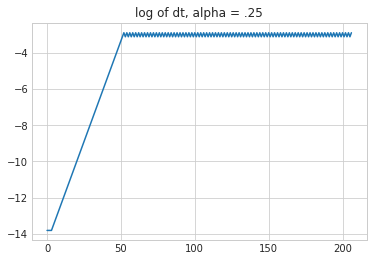

In [258]:
fig = plt.figure()
ax = plt.axes()
dts = list(map(lambda z: math.log(z[0] - z[1]), list(zip(ot[1:], ot))))
xlist = range(len(dts))
plt.plot(xlist, dts)
plt.title("log of dt, alpha = .25")

Steps Accepted:  218
Steps Rejected:  1


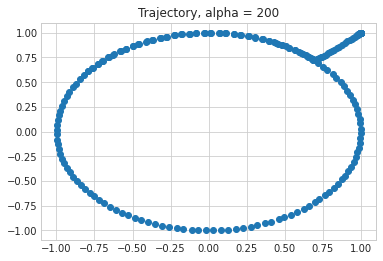

In [259]:
orbittime = simTime(0, .001, 1.25, .8, 10 ** -6, 1, 4 * math.pi)
startpos = np.array([1, 1])
ot, oy, ost, e2 = chart(0, startpos, 8, (orbit1, orbit2), orbittime, 200)

xpoint = []
ypoint = []
for i in oy:
    xpoint.append(i[0])
    ypoint.append(i[1])
fig = plt.figure()
ax = plt.axes()
plt.scatter(xpoint, ypoint)
plt.title("Trajectory, alpha = 200")
print("Steps Accepted: ", ost.stepsAccepted)
print("Steps Rejected: ", ost.stepsRejected)

Text(0.5, 1.0, 'log of dt, alpha = 200')

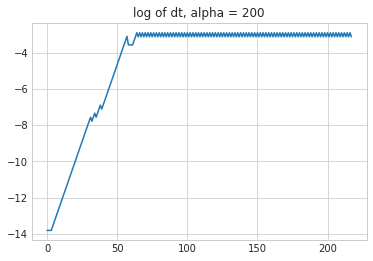

In [260]:
fig = plt.figure()
ax = plt.axes()
dts = list(map(lambda z: math.log(z[0] - z[1]), list(zip(ot[1:], ot))))
xlist = range(len(dts))
plt.plot(xlist, dts)
plt.title("log of dt, alpha = 200")

For the first problem, we can see that the alpha of .25 has a much looser spiral, that gradually approaches the circle value. With an alpha of 200, the trajectory immediately seeks out the circle. This is reflected in the log graphs; both experience an initial period where the steps are very small, and then once it has reached the circle the steps get to a larger and steady size. 

Text(0.5, 1.0, 'X Part, Tol = 10 * -3')

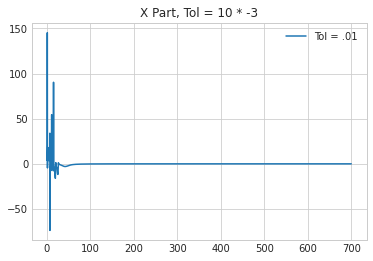

In [261]:
#Problem 2: Reaction Model

def react1(alpha, y):
    val1 = 77.27 * (y[1] - (y[0] * y[1]) + y[0] - (8.375 * (10 ** -6) * (y[0] ** 2)))
    val2 = (1/77.27) * (-y[1] - (y[0] * y[1]) + y[2])
    val3 = .161 * (y[0] - y[2])
    return np.array([val1, val2, val3])

def react2(alpha, y):
    #returns the hessian matrix
    topLeft = 77.27 * (1 - y[1] - (.00001675 * y[0]))
    topMid = 77.27 * (1 - y[0])
    topRight = 0
    midLeft = -y[1]/77.27
    midMid = (-y[0] - 1)/77.27
    midRight = 1/77.27
    botLeft = .161
    botMid = 0
    botRight = -.161
    return np.array([[topLeft, topMid, topRight], [midLeft, midMid, midRight], [botLeft, botMid, botRight]])

def newNorm(y):
    return (abs(y[0]) / (1.25 * (10 ** 5))) + (abs(y[1]) / 1800) + (abs(y[2]) / (3 * (10 ** 4)))

reacttime = simTime(0, 10 ** -3, 1.4, .8, 10 ** -6, 1, 700)
startpos = np.array([4, 1.1, 4])
ot3, oy3, ost3, err3 = chart(0, startpos, 700, (react1, react2), reacttime, .25, newNorm)
strictreacttime = simTime(0, 10 ** -6, 1.25, .8, 10 ** -6, 1, 700)
startpos = np.array([4, 1.1, 4])
otcon, oycon, ostcon, errcon = chart(0, startpos, 700, (react1, react2), strictreacttime, .25, newNorm)
x3 = []
y3 = []
z3 = []
xcon = []
ycon = []
zcon = []
for i in oy3:
    x3.append(i[0])
    y3.append(i[1])
    z3.append(i[2])
for j in oycon:
    xcon.append(j[0])
    ycon.append(j[0])
    zcon.append(j[0])
    
fig = plt.figure()
ax = plt.axes()
plt.plot(ot3, x3, label = 'Tol = .01')
plt.legend()
plt.title("X Part, Tol = 10 * -3")

Text(0.5, 1.0, 'Y Part, Tol = 10 * -3')

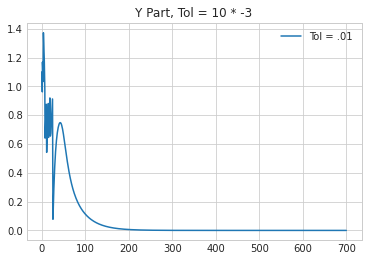

In [262]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot3, y3, label = 'Tol = .01')
plt.legend()
plt.title("Y Part, Tol = 10 * -3")

Text(0.5, 1.0, 'Z Part, Tol = 10 * -3')

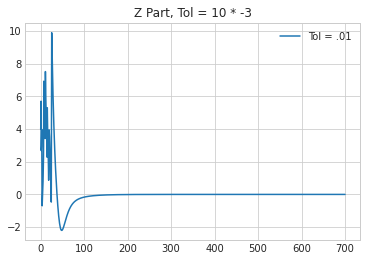

In [263]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot3, z3, label = 'Tol = .01')
plt.legend()
plt.title("Z Part, Tol = 10 * -3")

Text(0.5, 1.0, 'X Part, Tol = 10 * -3')

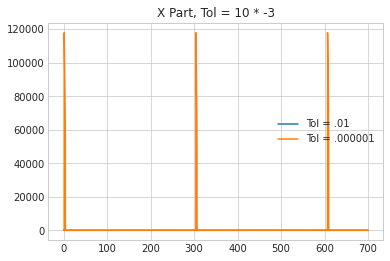

In [264]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot3, x3, label = 'Tol = .01')
plt.plot(otcon, xcon, label = 'Tol = .000001')
plt.legend()
plt.title("X Part, Tol = 10 * -3")

Text(0.5, 1.0, 'Y Part, Tol = 10 * -3')

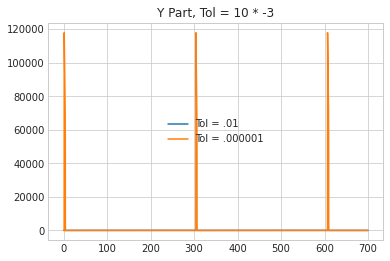

In [265]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot3, y3, label = 'Tol = .01')
plt.plot(otcon, ycon, label = 'Tol = .000001')
plt.legend()
plt.title("Y Part, Tol = 10 * -3")

Text(0.5, 1.0, 'Z Part, Tol = 10 * -3')

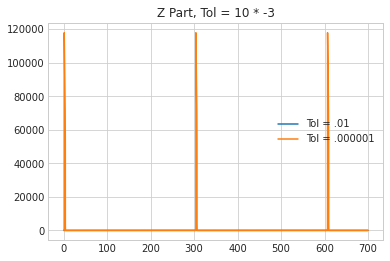

In [266]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot3, z3, label = 'Tol = .01')
plt.plot(otcon, zcon, label = 'Tol = .000001')
plt.legend()
plt.title("Z Part, Tol = 10 * -3")

Text(0.5, 1.0, 'X Part, Cutoff, Tol = 10 * -3')

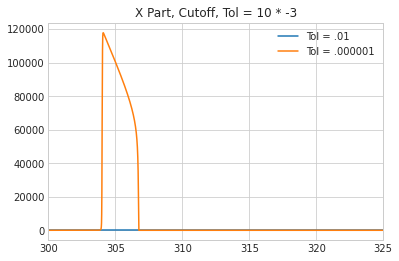

In [267]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot3, x3, label = 'Tol = .01')
plt.plot(otcon, xcon, label = 'Tol = .000001')
plt.legend()
ax.set_xlim([300, 325])
plt.title("X Part, Cutoff, Tol = 10 * -3")

Text(0.5, 1.0, 'Y Part, Cutoff, Tol = 10 * -3')

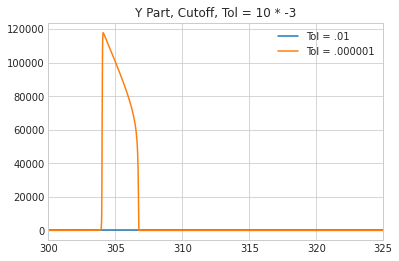

In [268]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot3, y3, label = 'Tol = .01')
plt.plot(otcon, ycon, label = 'Tol = .000001')
plt.legend()
ax.set_xlim([300, 325])
plt.title("Y Part, Cutoff, Tol = 10 * -3")

Text(0.5, 1.0, 'Z Part, Cutoff, Tol = 10 ^ -3')

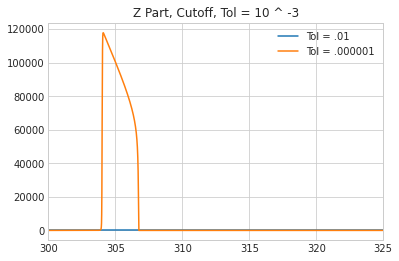

In [269]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot3, z3, label = 'Tol = .01')
plt.plot(otcon, zcon, label = 'Tol = .000001')
plt.legend()
ax.set_xlim([300, 325])
plt.title("Z Part, Cutoff, Tol = 10 ^ -3")

Text(0.5, 1.0, 'log of dt, tol = 10 ^ -3')

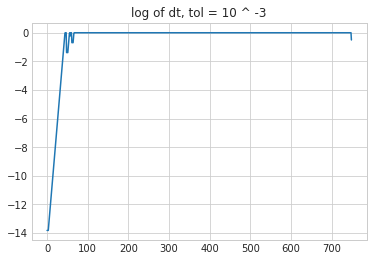

In [270]:
fig = plt.figure()
ax = plt.axes()
dts = list(map(lambda z: math.log(z[0] - z[1]), list(zip(ot3[1:], ot3))))
xlist = range(len(dts))
plt.plot(xlist, dts)
plt.title("log of dt, tol = 10 ^ -3")

Text(0.5, 1.0, 'Errors of Prediction, Tol = 10 ^ -3')

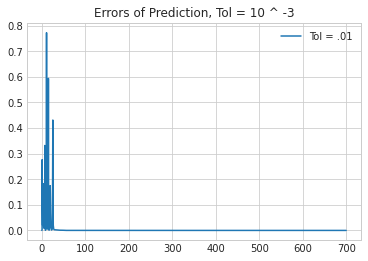

In [271]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot3, list(map(lambda y: y /(10 ** -3), err3)), label = 'Tol = .01')
#plt.plot(otcon, list(map(lambda y: y /(10 ** -6), errcon)), label = 'Tol = .000001')
plt.legend()
plt.title("Errors of Prediction, Tol = 10 ^ -3")

Text(0.5, 1.0, 'Errors of Prediction, Tol = 10 ^ -6')

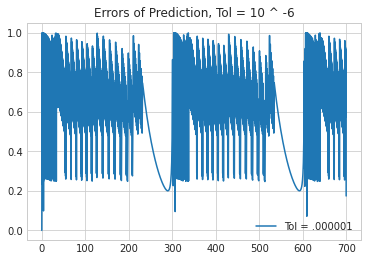

In [272]:
fig = plt.figure()
ax = plt.axes()
#plt.plot(ot3, list(map(lambda y: y /(10 ** -3), err3)), label = 'Tol = .01')
plt.plot(otcon, list(map(lambda y: y /(10 ** -6), errcon)), label = 'Tol = .000001')
plt.legend()
plt.title("Errors of Prediction, Tol = 10 ^ -6")

In [273]:
print("Tolerance = 10 ^ -3: Accepted", ost3.stepsAccepted)
print("Tolerance = 10 ^ -3: Rejected", ost3.stepsRejected)
print("Control: Accepted", ostcon.stepsAccepted)
print("Control: Rejected", ostcon.stepsRejected)

Tolerance = 10 ^ -3: Accepted 749
Tolerance = 10 ^ -3: Rejected 3
Control: Accepted 18785
Control: Rejected 1092


Text(0.5, 1.0, 'X Part, Tol = 10 ^ -4')

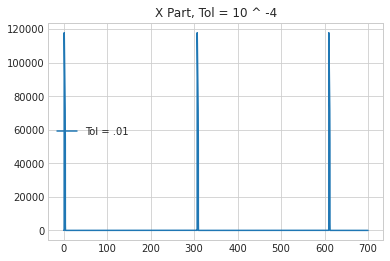

In [274]:
reacttime = simTime(0, 10 ** -4, 1.4, .8, 10 ** -6, 1, 700)
startpos = np.array([4, 1.1, 4])
ot4, oy4, ost4, err4 = chart(0, startpos, 700, (react1, react2), reacttime, .25, newNorm)
x4 = []
y4 = []
z4 = []

for i in oy4:
    x4.append(i[0])
    y4.append(i[1])
    z4.append(i[2])

fig = plt.figure()
ax = plt.axes()
plt.plot(ot4, x4, label = 'Tol = .01')
plt.legend()
plt.title("X Part, Tol = 10 ^ -4")

Text(0.5, 1.0, 'Y Part, Tol = 10 ^ -4')

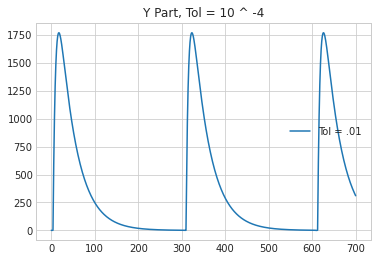

In [275]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot4, y4, label = 'Tol = .01')
plt.legend()
plt.title("Y Part, Tol = 10 ^ -4")

Text(0.5, 1.0, 'Z Part, Tol = 10 ^ -4')

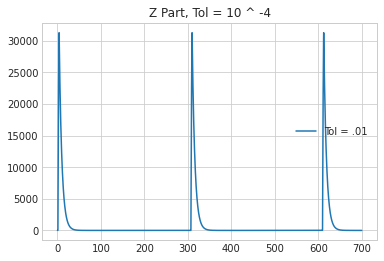

In [276]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot4, z4, label = 'Tol = .01')
plt.legend()
plt.title("Z Part, Tol = 10 ^ -4")

Text(0.5, 1.0, 'X Part, Tol = 10 ^ -4')

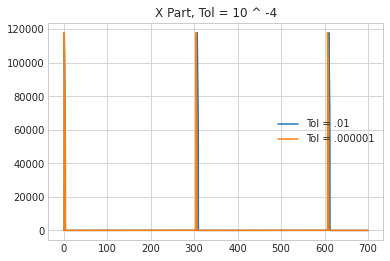

In [277]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot4, x4, label = 'Tol = .01')
plt.plot(otcon, xcon, label = 'Tol = .000001')
plt.legend()
plt.title("X Part, Tol = 10 ^ -4")

Text(0.5, 1.0, 'Y Part, Tol = 10 ^ -4')

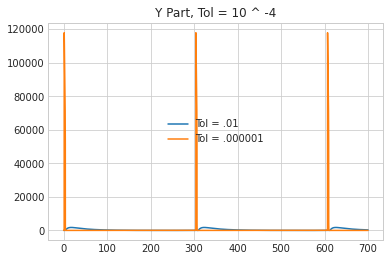

In [278]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot4, y4, label = 'Tol = .01')
plt.plot(otcon, ycon, label = 'Tol = .000001')
plt.legend()
plt.title("Y Part, Tol = 10 ^ -4")

Text(0.5, 1.0, 'Z Part, Tol = 10 ^ -4')

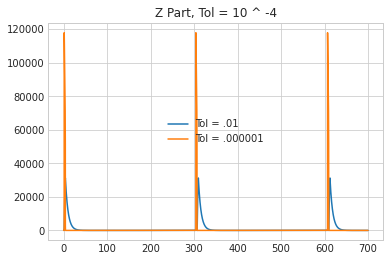

In [279]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot4, z4, label = 'Tol = .01')
plt.plot(otcon, zcon, label = 'Tol = .000001')
plt.legend()
plt.title("Z Part, Tol = 10 ^ -4")

(300.0, 325.0)

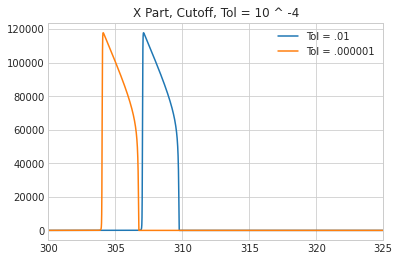

In [280]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot4, x4, label = 'Tol = .01')
plt.plot(otcon, xcon, label = 'Tol = .000001')
plt.legend()
plt.title("X Part, Cutoff, Tol = 10 ^ -4")
ax.set_xlim([300, 325])

(300.0, 325.0)

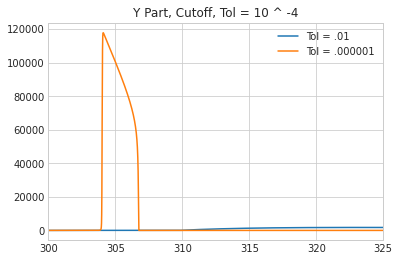

In [281]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot4, y4, label = 'Tol = .01')
plt.plot(otcon, ycon, label = 'Tol = .000001')
plt.legend()
plt.title("Y Part, Cutoff, Tol = 10 ^ -4")
ax.set_xlim([300, 325])

(300.0, 325.0)

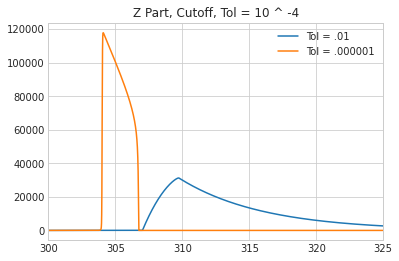

In [282]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot4, z4, label = 'Tol = .01')
plt.plot(otcon, zcon, label = 'Tol = .000001')
plt.legend()
plt.title("Z Part, Cutoff, Tol = 10 ^ -4")
ax.set_xlim([300, 325])

Text(0.5, 1.0, 'log of dt, tol = 10 ^ -4')

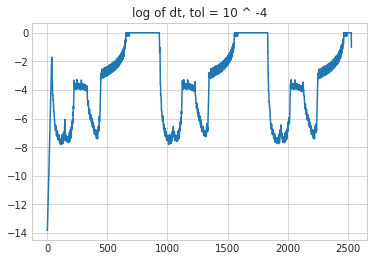

In [283]:
fig = plt.figure()
ax = plt.axes()
dts = list(map(lambda z: math.log(z[0] - z[1]), list(zip(ot4[1:], ot4))))
xlist = range(len(dts))
plt.plot(xlist, dts)
plt.title("log of dt, tol = 10 ^ -4")

Text(0.5, 1.0, 'Errors of Prediction, Tol = 10 ^ -4')

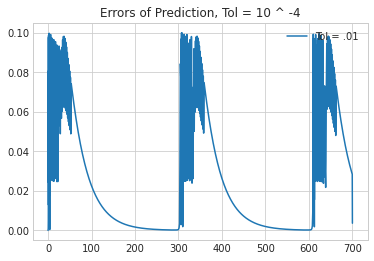

In [284]:
fig = plt.figure()
ax = plt.axes()
plt.plot(ot4, list(map(lambda y: y /(10 ** -3), err4)), label = 'Tol = .01')
#plt.plot(otcon, list(map(lambda y: y /(10 ** -6), errcon)), label = 'Tol = .000001')
plt.legend()
plt.title("Errors of Prediction, Tol = 10 ^ -4")

In [285]:
print("Tolerance = 10 ^ -4: Accepted", ost4.stepsAccepted)
print("Tolerance = 10 ^ -4: Rejected", ost4.stepsRejected)
print("Control: Accepted", ostcon.stepsAccepted)
print("Control: Rejected", ostcon.stepsRejected)

Tolerance = 10 ^ -4: Accepted 2529
Tolerance = 10 ^ -4: Rejected 316
Control: Accepted 18785
Control: Rejected 1092
